<a href="https://colab.research.google.com/github/afeld/nyu-python-public-policy/blob/master/lecture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NYU Wagner - Python Coding for Public Policy**
# Class 4: Linear regression and correlation analysis

# LECTURE

## Importing necessary packages

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.api as sm # package for doing statistics

In [ ]:
# You can use pd.set_option() to make sure you see all the rows and columns in your dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
drive.mount('/content/drive')
# follow the link it generates, choose your account, and then paste in the authorization code it provides

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data preparation

### Load datasets we'll use:
- 311 requests
- community district population

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Data for Python/cleaned_311_data_revised.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,19,20,22,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Data source for population by Community District: https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Community-Districts/xi7c-iiu2/data
# This time we'll load it directly from NYC Open Data instead of from Google Drive
population = pd.read_csv('https://data.cityofnewyork.us/api/views/xi7c-iiu2/rows.csv?accessType=DOWNLOAD')

### Add borocd column to all 311 requests in the full 311 requests dataset, using an improved function

In [ ]:
# this function will recode the community_board value into borocd in a new column
# i've added logic to it that now also checks if the CD number is valid

def recode_borocd(row):

  text = row.community_board
  first2chars = row.community_board[0:2]

  if row.community_board[0] != 'U':
    if ('MANHATTAN' in text) and (int(first2chars) <= 12):
      return '1' + first2chars
    elif ('BRONX' in text) and (int(first2chars) <= 12):
      return '2' + first2chars
    elif ('BROOKLYN' in text) and (int(first2chars) <= 18):
      return '3' + first2chars
    elif ('QUEENS' in text) and (int(first2chars) <= 14):
      return '4' + first2chars
    elif ('STATEN ISLAND' in text) and (int(first2chars) <= 3):
      return '5' + first2chars
  else:
    return 'Invalid borocd'

df['borocd'] = df.apply(recode_borocd, axis=1)

In [ ]:
# let's only keep complaint records with valid borocds

df = df[df.borocd != 'Invalid borocd']

In [ ]:
# saving to google drive so everyone can use this cleaned version

df.to_csv('cleaned_311_data_revised.csv')
!cp cleaned_311_data_revised.csv drive/My\ Drive/

Note: you can define an object inside a function that will only exist inside that function

In [ ]:
test_string = 'original text'
print(test_string)

def test_function():
  test_string = 'new test_string created inside the function'
  print(test_string)

test_function()

print(test_string)

### Create borocd column in community district population dataset

In [ ]:
# Create a function recode_borocd_pop that combines and recodes the Borough and CD Number values to create a borocd unique ID

def recode_borocd_pop(row):
  if row.Borough == 'Manhattan':
    return 100 + row['CD Number']
  elif row.Borough == 'Bronx':
    return 200 + row['CD Number']
  elif row.Borough == 'Brooklyn':
    return 300 + row['CD Number']
  elif row.Borough == 'Queens':
    return 400 + row['CD Number']
  elif row.Borough == 'Staten Island':
    return 500 + row['CD Number']
  else:
    return 'Invalid borocd'

population['borocd'] = population.apply(recode_borocd_pop, axis=1)

### Join the population data onto the counts data after creating shared `borocd` unique ID

In [ ]:
cd_counts = df.groupby('borocd').size().reset_index(name='count_of_311_requests')

In [ ]:
# now lets join this population data onto our CD dataset
# the default setting for merge is an inner join

cd_data = pd.merge(left=cd_counts, right=population, left_on='borocd', right_on='borocd')

In [ ]:
# let's create a simplified new dataframe that only include the columns we care about and in a better order

cd_data = cd_data[['borocd', 'Borough', 'CD Name', '2010 Population', 'count_of_311_requests']]
cd_data.head()

,borocd,Borough,CD Name,2010 Population,count_of_311_requests
0,101.0,Manhattan,"Battery Park City, Tribeca",60978,21259
1,102.0,Manhattan,"Greenwich Village, Soho",90016,36688
2,103.0,Manhattan,"Lower East Side, Chinatown",163277,51399
3,104.0,Manhattan,"Chelsea, Clinton",103245,38819
4,105.0,Manhattan,Midtown Business District,51673,37466


## Make a scatterplot of count of 311 requests per CD against CD population

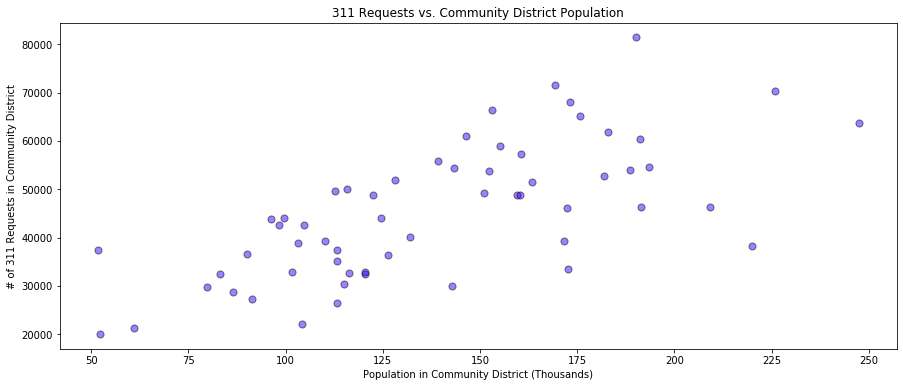

In [ ]:
plt.figure(figsize=(15, 6))

plt.scatter(
    np.array(cd_data['2010 Population']/1000), # x
    np.array(cd_data.count_of_311_requests), # y
    s=50, # size of marker
    c='#3d03fc', # color hex color picker: https://www.google.com/search?q=color+picker
    edgecolors='black', # outline color of the marker
    alpha=0.5) # transparency. 0 is 100% transparent. 1 is 100% opaque

plt.title('311 Requests vs. Community District Population')
plt.xlabel('Population in Community District (Thousands)')
plt.ylabel('# of 311 Requests in Community District')

plt.show()

## How well does count of 311 requests correlate with population per community district?

In [ ]:
# determine the correlation coefficient using the np.corrcoef() function from numpy

x = np.array(cd_data['2010 Population']/1000)
y = np.array(cd_data.count_of_311_requests)

# produces a matrix of the correlation coefficients
np.corrcoef(x, y)

array([[1.        , 0.68621761],
       [0.68621761, 1.        ]])

Moderately high positive correlation

## How well can a linear regression predict the relationship between population and 311 requests per community district

In [ ]:
# Note that y is the first argument, before x. This is different than plotting and the correlation function.

# y = dependent variable (# of 311 requests)
y = np.array(cd_data.count_of_311_requests)

# x = independent variable (population) with a constant added
x = np.array(cd_data['2010 Population']/1000)
x = sm.add_constant(x)

print(x)

model = sm.OLS(y, x).fit()

# Print out the statistics

print(model.summary())

[[  1.     60.978]
 [  1.     90.016]
 [  1.    163.277]
 [  1.    103.245]
 [  1.     51.673]
 [  1.    142.745]
 [  1.    209.084]
 [  1.    219.92 ]
 [  1.    110.193]
 [  1.    115.723]
 [  1.    120.511]
 [  1.    190.02 ]
 [  1.     91.497]
 [  1.     52.246]
 [  1.     79.762]
 [  1.    146.441]
 [  1.    128.2  ]
 [  1.     83.268]
 [  1.    139.286]
 [  1.    101.731]
 [  1.    172.298]
 [  1.    120.392]
 [  1.    113.232]
 [  1.    152.344]
 [  1.    173.083]
 [  1.     99.617]
 [  1.    152.985]
 [  1.    112.634]
 [  1.    182.896]
 [  1.    104.709]
 [  1.    126.23 ]
 [  1.     96.317]
 [  1.     98.429]
 [  1.    124.491]
 [  1.    181.981]
 [  1.    191.382]
 [  1.    104.278]
 [  1.    160.664]
 [  1.    159.65 ]
 [  1.     86.468]
 [  1.    155.252]
 [  1.    193.543]
 [  1.    191.105]
 [  1.    113.2  ]
 [  1.    171.576]
 [  1.    172.598]
 [  1.    169.19 ]
 [  1.    113.257]
 [  1.    247.354]
 [  1.    151.107]
 [  1.    143.317]
 [  1.    122.396]
 [  1.    11

Based on the R2 value, the linear model with a y-intercept only explains 47% of the variance in 311 counts per community district

If you didn't include the constant in your x input, the linear model R2 would be higher than it should be. ["Why are R2 and F so large for models without a constant?"](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-why-are-r2-and-f-so-large-for-models-without-a-constant/ )

## We can access the model results and save them as objects

In [ ]:
p = model.params # intercept and coefficient
print('parameters:', p)

r2 = model.rsquared
print('R2:', r2)

parameters: [15275.92042017   217.26495595]
R2: 0.4708946065516594


In [ ]:
# let's make labels for the lines of the best fit to use on a scatter plot

label = 'y = ' + str(round(p[1],2)) + 'x + ' + str(round(p[0],2)) + '; R2 = ' + str(round(r2,3))
print(label)

y = 217.26x + 15275.92; R2 = 0.471


## Adding the lines of best fit to the scatter plot

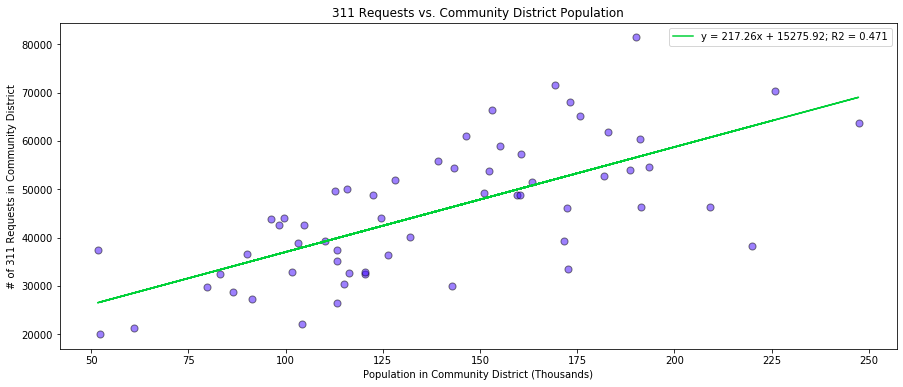

In [ ]:
# create an array of x values for the lines of best fit
# x_dummy = np.arange(0,max(cd_data['2010 Population'])/1000)
x_dummy = np.array(cd_data['2010 Population']/1000)

plt.figure(figsize=(15, 6))

plt.scatter(
    np.array(cd_data['2010 Population']/1000), # x
    np.array(cd_data.count_of_311_requests), # y
    s=50, # size of marker
    c='#3d03fc', # color hex color picker: https://www.google.com/search?q=color+picker
    edgecolors='black', # outline color of the marker
    alpha=0.5) # transparency. 0 is 100% transparent. 1 is 100% opaque

# line of best fit, with y intercept
plt.plot(
    x_dummy, 
    p[0] + p[1] * x_dummy,
    c='#00d138', # lighter green
    label=label)

plt.title('311 Requests vs. Community District Population')
plt.xlabel('Population in Community District (Thousands)')
plt.ylabel('# of 311 Requests in Community District')
plt.legend()

plt.show()

## Using the `seaborn` package to easily produce pretty regression charts
Reference: https://seaborn.pydata.org/tutorial/regression.html

In [ ]:
import seaborn as sns

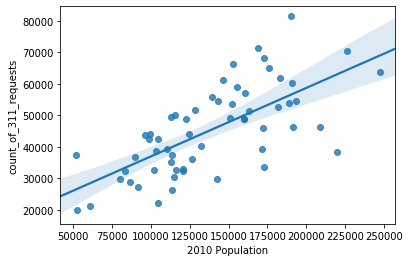

In [ ]:
# the .regplot() function makes a nice looking scatter plot with a line of best fit
# it can consume pandas data series from a dataframe

sns.regplot(
    x=cd_data['2010 Population'],
    y=cd_data['count_of_311_requests'])

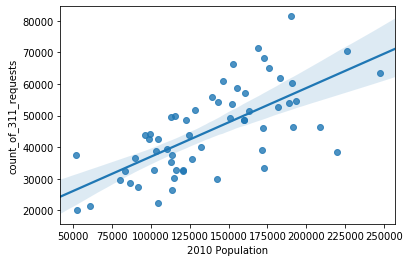

In [ ]:
# the .regplot() function makes a nice looking scatter plot with a line of best fit
# it can also consume column names and a specified dataframe

sns.regplot(
    x='2010 Population', # note that x and y are the column names in the specified "data" table
    y='count_of_311_requests',
    data=cd_data)

## Helpful reference on polynomial and multiple regression
https://blog.datarobot.com/multiple-regression-using-statsmodels

# HOMEWORK 4 Coding: The relationship between concentration of homeless shelters and count of 311 requests related to homeless services

**Problem Statement**: Homelesses is a big concern in New York City. The Department of Homeless Services is tasked with providing services and housing for people who are homeless. They recently began publishing the count of homeless shelter buildings per community district on NYC Open Data to provide more transparency into where shelters are located. The dataset provides counts in multiple columns for different categories of buildings. It also includes counts from different reporting dates.

The 311 Service Requests dataset includes a complaint type called "Homeless Person Assistance". Let's find out if there's a relationship between the number of homeless assistance 311 requests and the concentration of homeless shelter buildings per community district.

**Step 1**. Load the datasets:
- Cleaned 311 data that excludes records with invalid community districts. Shared with you on Google Drive as `cleaned_311_data_revised.csv`
- NYC Open dataset that provides the total count of different types of homeless shelter buildings per community district. 
  - Data source page where you can preview the data: https://data.cityofnewyork.us/Social-Services/Buildings-by-Borough-and-Community-District/3qem-6v3v/data
  - CSV data download link you can plug into the `pd.read_csv()` function: https://data.cityofnewyork.us/api/views/3qem-6v3v/rows.csv?accessType=DOWNLOAD

**Step 2**. Filter the shelter count dataframe to only keep rows where the value in the 'Report Date' column is '09/30/2019'

**Step 3**. Create a new column in the shelter count dataframe that calculates the sum of all the individual count columns: 'Adult Family Comm Hotel', 'Adult Family Shelter', 'Adult Shelter', 'Adult Shelter Comm Hotel', 'FWC Cluster', 'FWC Comm Hotel', 'FWC Shelter'

- Tip: There are multiple ways to add these columns together. With one approach, you may find that your total column contains NaN values. This is because many of the columns contains NaN/empty values. When you add a real number to a NaN, the sum will be NaN. To get around this, you will need to fill in all the NaN values with 0 instead. Use the `.fillna(0)` method on your shelter count dataframe.

**Step 4**. From the 311 dataset, create a subset of all the 311 requests where `complaint_type == 'Homeless Person Assistance'`

**Step 5**. Group the 311 subset by 'borocd' to get the count of 'Homeless Person Assistance' requests per community district

**Step 6**. Merge the homeless 311 request count table (from Step 5) with the shelter count table (from Step 3).
- Tip: Not all community districts have homeless facilities in them. Use a left join with the 311 complaints as the left table and shelter counts as the right table. After doing this, you should fill in the new NaNs with zeros using the `.fillna(0)` method on your dataframe.

**Step 7**. Produce a scatter plot of the data using the `matplotlib` package. What is your initial impression on whether there is a correlation between number of shelters and count of 311 homeless service requests?

**Step 8**. Use `np.corrcoef(x, y)` to identify the correlation coefficient between count of total shelter buildings and count of homeless requests per community district.

**Step 9**. Perform a linear regression with count of total shelter buildings as the independent variable and count of homeless requests as the dependent variable



**Step 10**. Produce a scatter plot of the data with the line of best fit from your linear regression using the `matplotlib` package

**Step 11**: Write a sentence or two explaining the results of your analysis. What do the numbers and chart tell you about the relationship between concentration of homeless shelters vs. frequency of 311 requests related to homelessness?

**Additional context on 311 use cases related to homeless services**:
- What do "Homeless Person Assistance" requests actually entail? https://www1.nyc.gov/site/dhs/outreach/street-outreach.page
- 311 web page encouraging residents of shelters to complain about unsuitable conditions. Unfortunately those complaints are not clearly labeled in the 311 data. https://portal.311.nyc.gov/article/?kanumber=KA-01039
- News article referencing conditions in shelters and residents reporting problems through 311. https://www.nydailynews.com/new-york/nyc-homeless-shelter-residents-call-311-no-listening-article-1.2759222


# HOMEWORK 4 Tutorial: Time series data

[Tutorial: Time Series Analysis with Pandas](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)